## Tutorial VANs Amplitude Channel Discrimination: Optimal input

##### Loading the library

In [1]:
%load_ext autoreload
%autoreload 2

from datetime import datetime
import numpy as np
import pandas as pd
import tensorflow as tf
import cirq
import tensorflow_quantum as tfq
import matplotlib.pyplot as plt

from utilities.circuit_basics import Basic
from utilities.idinserter import IdInserter
from utilities.qmodels import *
from utilities.variational import Minimizer
from utilities.simplifier import Simplifier
from utilities.unitary_killer import UnitaryMurder
from utilities.evaluator import Evaluator


In [2]:
basic = Basic(n_qubits=2, env_mode=1) #this is the module where basic functions are defined (and the rest of the modules inherits this classs)
inserter = IdInserter(n_qubits=basic.n_qubits) # we use this to insert gates in the circuit
minimizer = Minimizer(n_qubits=basic.n_qubits, epochs=10**3, env_mode = basic.env_mode) # we use this to minimize cost functions  (e.g. error probabilities)
simplifier = Simplifier(n_qubits=basic.n_qubits) #we use this to (if possible) reduce the circuit to an equivalent one whose depth is smaller
killer = UnitaryMurder(minimizer=minimizer) #we use this to delete gates that do not decrease the error probability very much

Let's now define the parameters of the channels to discriminate

In [3]:
eta0 = 0.01
eta1 = 1.  

arguments={"problem_name":"QADC", "params":[eta0,eta1], "n_qubits":2, "env_mode":1}
evaluator = Evaluator(args = arguments) 

Define now an initial circuit to depart from. For this, CREATE INITIAL CIRCUIT CONSISTING ON ENCODER (block_id=0) CHANNEL (block_id=1) DECODER (block_id=2).

Note we will create a "batch" of circuits, each having a different channel, to compute the error probability (this is done later).


In [4]:
circuit=[]
### ENCODER BLOCK
circuit = [basic.give_gate_template(k, block_id=0, trainable=True) for k in basic.rotation_series(0, exclude=1)] ## begin from z rotation (nothing)

## CHANNEL BLOCK ##
circuit += basic.give_channel_circuit_db([0,basic.env_mode], eta=eta0, block_id=1)  ###arbitrary choose one parameter

## DECODER BLOCK ##
#circuit += [basic.give_gate_template(k, block_id=2, trainable=True) for k in basic.rotation_series(0, exclude=1)] ## begin from z rotation (nothing)


circuit, symbols, circuit_db = basic.give_circuit(circuit)
circuit #let's print the circuit's object (CIRQ)

(0, 0): ───Rz(th_0)───H───X────────────────X───H────────────────X───
                          │                │                    │
(0, 1): ───H──────────────@───Ry(0.006π)───@───H───Ry(0.006π)───@───

In [8]:
batch = basic.prepare_channel_discrimination_circuits(circuit_db, other_eta=eta1) # here you see the remaining channel.

evaluator = Evaluator(args = arguments) 
start = datetime.now()

##### TRAIN ONCE #####
error_prob, symbol_to_value, training_evolution = minimizer.channel_discrimination(batch)
circuit_db = basic.update_circuit_db_param_values(circuit_db, symbol_to_value)    ## update database param_values
evaluator.add_step(circuit_db, error_prob, relevant=True)
print(evaluator.displaying["information"])

for it_vans in range(10):
    info = "Iteration number {}\nTime from start {}\nLowest Perr found {}\n\n".format(it_vans, str(datetime.now()-start), np.round(evaluator.lowest_energy,3) )
    print(info)
    
    evaluator.displaying["information"] += info
    print(evaluator.give_circuit_from_db(circuit_db)[0])
    print("\n")
    ### ADD IDENTITIES ALL OVER THE CIRCUIT ###
    mutated_circuit_db = inserter.place_identities(circuit_db)
    
    ### SIMPLIFY CIRCUIT ####
    simplified_circuit_db = simplifier.simplify_blocks(mutated_circuit_db)
    
    ### TRAIN (MUTATED+SIMPLIFIED) CIRCUIT
    batch_simplified = basic.prepare_channel_discrimination_circuits(simplified_circuit_db)
    perr, symbol_to_value, training_evolution = minimizer.channel_discrimination(batch_simplified)
    simplified_circuit_db = basic.update_circuit_db_param_values(simplified_circuit_db, symbol_to_value)
    accept_mutation = evaluator.accept_energy(perr, decrease_only=True)
    
    if accept_mutation == True:
        ## Kill unnecessary gates + simplification rules if mutation is accepted
        lmax = len(circuit_db["trainable"] == True)
        reduced = True
        cnt=0
        while reduced is True:
            # KILL single-qubit gates 
            killed_circuit_db, perr, reduced, unitaries_killed = killer.unitary_slaughter(simplified_circuit_db)
            simplified_circuit_db = simplifier.simplify_blocks(killed_circuit_db)
            cnt+=1
        circuit_db = simplified_circuit_db
    ### save results of iteration ###w
    evaluator.add_step(circuit_db, perr, relevant=accept_mutation)



 Hola, I'm VANS, and current local time is 2021-11-04 13:46:52.784101 

Iteration number 0
Time from start 0:00:01.316398
Lowest Perr found 0.19099999964237213


(0, 0): ───Rx(0.175π)───@────────────────@───H───X────────────────X───H────────────────X───
                        │                │       │                │                    │
(0, 1): ────────────────X───Rz(-1.89π)───X───H───@───Ry(0.006π)───@───H───Ry(0.006π)───@───


Iteration number 1
Time from start 0:00:02.957417
Lowest Perr found 0.19099999964237213


(0, 0): ───Rx(0.175π)───@────────────────@───H───X────────────────X───H────────────────X───
                        │                │       │                │                    │
(0, 1): ────────────────X───Rz(-1.89π)───X───H───@───Ry(0.006π)───@───H───Ry(0.006π)───@───


Iteration number 2
Time from start 0:00:04.607487
Lowest Perr found 0.19099999964237213


(0, 0): ───Rx(0.175π)───@────────────────@───H───X────────────────X───H────────────────X───
               

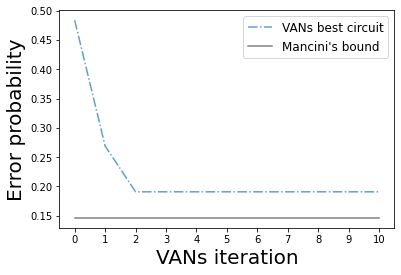

In [7]:
evaluator.show_evolution(raw=True)

In [78]:
evaluator.give_circuit_from_db(circuit_db)[0]

(0, 0): ───X───Rx(-0.902π)───H───X────────────────X───H────────────────X───
           │                     │                │                    │
(0, 1): ───@───H─────────────────@───Ry(0.006π)───@───H───Ry(0.006π)───@───

In [79]:
circuit_db

,ind,symbol,param_value,trainable,block_id,channel_param
0,1,None,NaN,True,0,None
1,4,th_0,-2.83374,True,0,None
2,8,None,NaN,False,1,None
3,9,None,NaN,False,1,None
4,1,None,NaN,False,1,None
5,7,th_7,0.02000,False,1,True
6,1,None,NaN,False,1,None
7,8,None,NaN,False,1,None
8,9,None,NaN,False,1,None
9,7,th_8,0.02000,False,1,True


In [80]:
simplifier.simplify_blocks(circuit_db)

,ind,symbol,param_value,trainable,block_id,channel_param
0,4,th_0,-2.83374,True,0,None
1,5,th_1,0.00000,True,0,None
2,8,None,NaN,False,1,None
3,9,None,NaN,False,1,None
4,1,None,NaN,False,1,None
5,7,th_7,0.02000,False,1,True
6,1,None,NaN,False,1,None
7,8,None,NaN,False,1,None
8,9,None,NaN,False,1,None
9,7,th_8,0.02000,False,1,True
